<a href="https://colab.research.google.com/github/JeonDaehan/Surface_Crack_Detection/blob/master/Surface_Crack_Detection_Kaggle_project_acc99_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import to_categorical

from datetime import datetime
import os
import glob
import shutil
import random
import cv2
from google.colab import drive
import zipfile

In [ ]:
# 구글 드라이브와 연동하기
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [ ]:
# 짚파일을 맨 첫번째 페이지에 노출되게 하기.
dataset_path = "/content/gdrive/MyDrive/Colab Notebooks"
shutil.copy(os.path.join(dataset_path, "surface_crack.zip"), "/content")

'/content/surface_crack.zip'

In [ ]:
# 관리할 폴더 미리 지정해주기(만들어주는게 아님)

DATA_ROOT_DIR = os.path.join("/content", "surface_crack")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "train") # train이라는 폴더를 만들어 주겠다.
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "test")
# label_name_list = 폴더이름이자 정답이름

In [ ]:
# 압축 풀어주기 (풀면 파일이 만들어짐)
with zipfile.ZipFile(os.path.join("/content", "surface_crack.zip"), "r") as target_file:
  target_file.extractall(DATA_ROOT_DIR)
    

In [ ]:
# 풀어놓은 전체 데이터를 TRAIN파일에 옮겨주자

shutil.copytree(DATA_ROOT_DIR, TRAIN_DATA_ROOT_DIR) # COPYTREE는 기존에 똑같은 이름의 폴더가 있으면 에러가 생김.

'/content/surface_crack/train'

In [ ]:
# TEST폴더 만들어주자 / 기존에 같은 명의의 파일이 있으면 에러생김
os.mkdir(TEST_DATA_ROOT_DIR)
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, "Positive"))
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, "Negative"))

In [ ]:
# Train에 있는 파일들 test에 20프로 옮겨주기, randomshuffle
label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
MOVE_RATIO = 0.2

for label_name in label_name_list:
  src_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
  dst_dir_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)


  # train에 있는 데이터 random하게 섞어주기
  train_data_file_list = os.listdir(src_dir_path)
  random.shuffle(train_data_file_list)

  split_num = int(MOVE_RATIO * len(train_data_file_list)) # 개수를 정수로 나눠줘야 하기때문에 int
  test_data_file_list = train_data_file_list[0:split_num]

  # 실제 파일 이동
  for f in test_data_file_list:
    shutil.move(os.path.join(src_dir_path, f), os.path.join(dst_dir_path, f))

In [ ]:
# 실제 이미지를 메모리에 올려놓자

train_data_list = []
train_label_list = []

class_dict = {"Negative":0, "Positive":1}

for label_name in label_name_list:
  file_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
  img_file_list = glob.glob(file_path + "/*.jpg")


# 이미지, 색, 순서(bgr->rgb)
  for img in img_file_list:
    src_img = cv2.imread(img,cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(64,64))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    train_data_list.append(src_img)
    train_label_list.append(class_dict[label_name])

In [ ]:
X_train = np.array(train_data_list).astype("float32")
y_train = np.array(train_label_list).astype("float32")

In [ ]:
print(X_train.shape, y_train.shape)

(32000, 64, 64, 3) (32000,)


In [ ]:
# 실제 이미지를 메모리에 올려놓자 test

test_data_list = []
test_label_list = []

for label_name in label_name_list:
  file_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
  img_file_list = glob.glob(file_path + "/*.jpg")


# 이미지, 색, 순서(bgr->rgb)
  for img in img_file_list:
    src_img = cv2.imread(img,cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(64,64))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    test_data_list.append(src_img)
    test_label_list.append(class_dict[label_name])

In [ ]:
X_test = np.array(test_data_list).astype("float32")
y_test = np.array(test_label_list).astype("float32")

In [ ]:
print(X_test.shape, y_test.shape)

(8000, 64, 64, 3) (8000,)


In [ ]:
# 정규화

X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
# 모델 설계 cmd cmd fdd (sigmoid, binary)
model = Sequential()

model.add(Conv2D(kernel_size=3, filters=32, activation="relu", 
                 padding="SAME", input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(kernel_size=3, filters=64, activation="relu", 
                 padding="SAME",))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# 출력 개수가 1인 이유는 이중분류는 1로만 한다.
# 다중 출력이라면 원핫코딩의 개수만큼 적어준다.


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 16, 16, 64)       

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

result = model.fit(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[earlystopping])


## C-P-C-P-C-P-F-D-D
## lr 0.0001 => loss: 0.0102 - accuracy: 0.9969 - val_loss: 0.0237 - val_accuracy: 0.9930 과적합 
## lr 0.00001 => loss: 0.0317 - accuracy: 0.9905 - val_loss: 0.0390 - val_accuracy: 0.9944 

## C-P-C-P-F-D-D 
## lr 0.0001 => loss: 0.0146 - accuracy: 0.9956 - val_loss: 0.0103 - val_accuracy: 0.9966
## lr 0.00001 => loss: 0.0482 - accuracy: 0.9854 - val_loss: 0.0130 - val_accuracy: 0.9986

Epoch 1/30
800/800 [==============================] - 6s 7ms/step - loss: 0.6677 - accuracy: 0.6161 - val_loss: 0.7740 - val_accuracy: 1.5625e-04
Epoch 2/30
800/800 [==============================] - 5s 7ms/step - loss: 0.6102 - accuracy: 0.6633 - val_loss: 0.2530 - val_accuracy: 0.9998
Epoch 3/30
800/800 [==============================] - 7s 9ms/step - loss: 0.4183 - accuracy: 0.8233 - val_loss: 0.0665 - val_accuracy: 0.9994
Epoch 4/30
800/800 [==============================] - 6s 7ms/step - loss: 0.2826 - accuracy: 0.9025 - val_loss: 0.0397 - val_accuracy: 0.9994
Epoch 5/30
800/800 [==============================] - 5s 7ms/step - loss: 0.2157 - accuracy: 0.9305 - val_loss: 0.0276 - val_accuracy: 0.9994
Epoch 6/30
800/800 [==============================] - 5s 7ms/step - loss: 0.1738 - accuracy: 0.9448 - val_loss: 0.0203 - val_accuracy: 0.9994
Epoch 7/30
800/800 [==============================] - 5s 7ms/step - loss: 0.1498 - accuracy: 0.9515 - val_loss: 0.0161 - val_accuracy: 0.9994
Ep

In [ ]:
model.evaluate(X_test, y_test)

### C-P-C-P-C-P-F-D-D
## lr 0.00001 [0.04126840457320213, 0.9888749718666077] 정확성과 과적합이 없음
## lr 0.0001 [0.03228703513741493, 0.9911249876022339] 과적합


### C-P-C-P-F-D-D
## lr 0.00001 [0.13723982870578766, 0.9537500143051147] 정확성이 떨어짐.
## lr 0.0001 [0.019934188574552536, 0.9948750138282776] 과적합

250/250 [==============================] - 1s 4ms/step - loss: 0.1372 - accuracy: 0.9538


[0.13723982870578766, 0.9537500143051147]

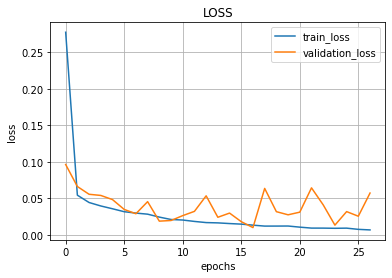

In [ ]:
### C-P-C-P-C-P-F-D-D
## lr 0.0001

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

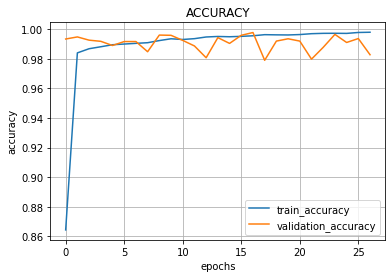

In [ ]:
### C-P-C-P-C-P-F-D-D
## lr 0.0001

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()

plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")

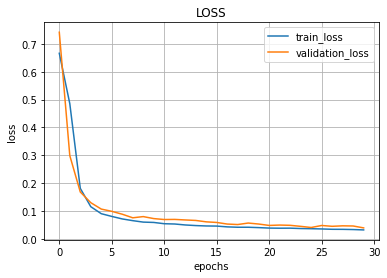

In [ ]:
### C-P-C-P-C-P-F-D-D
## lr 0.00001

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

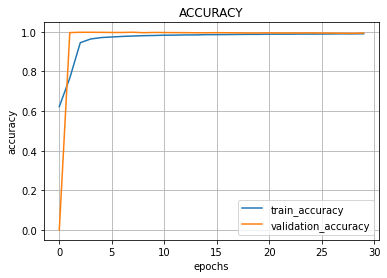

In [ ]:
## C-M-C-M-C-M-F-D-D
## lr 0.00001

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()

plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")

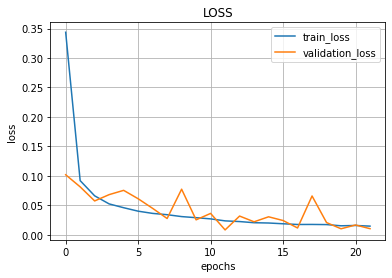

In [ ]:
### C-P-C-P-F-D-D
## lr 0.0001

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

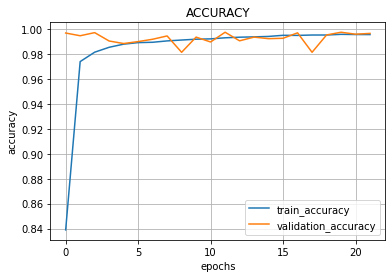

In [ ]:
### C-P-C-P-F-D-D
## lr 0.0001

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()

plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")

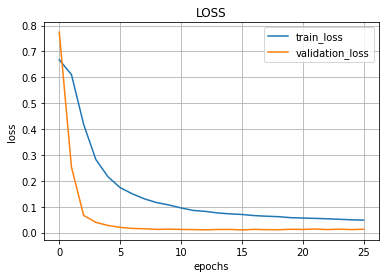

In [ ]:
### C-P-C-P-F-D-D
## lr 0.0001

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

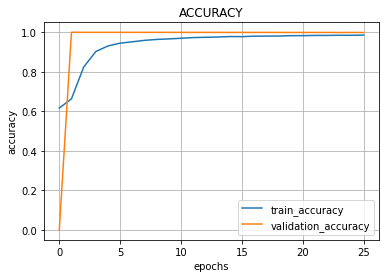

In [ ]:
### C-P-C-P-F-D-D
## lr 0.0001

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()

plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")

최종적으로 모델의 정확성이 가장 높았던 "C-P-C-P-C-P-F-D-D"모델로 채택하고, 과적합이 최소화 되었던 lr = 0.00001로 설정하여 99%의 모델을 만들었다. 

In [ ]:
D